# 05 — Time Series Forecasting with ARIMA (PM2.5)
Mục tiêu:
- Làm sạch + chuẩn hoá chuỗi theo tần suất giờ (hourly) và xử lý missing.
- Kiểm tra **trend / seasonality / stationarity** (ADF, KPSS), ACF/PACF.
- Chọn tham số **(p,d,q)** bằng grid nhỏ (AIC/BIC) và dự báo bằng **ARIMA**.

> Lưu ý: Notebook này **chỉ dùng ARIMA** (statsmodels). 


In [1]:
from pathlib import Path
import sys

USE_UCIMLREPO = False
RAW_ZIP_PATH_REL = 'data/raw/PRSA2017_Data_20130301-20170228.zip'

# Tự động tìm PROJECT_ROOT (thư mục chứa src/)
cwd = Path.cwd().resolve()
PROJECT_ROOT = cwd
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'src').exists():
    raise FileNotFoundError("Không tìm thấy thư mục 'src' trong cây thư mục hiện tại.")

# Bảo đảm import được package trong src
sys.path.insert(0, str(PROJECT_ROOT))

# Chuẩn hoá đường dẫn tuyệt đối
RAW_ZIP_PATH = str((PROJECT_ROOT / RAW_ZIP_PATH_REL).resolve())

STATION = 'Aotizhongxin'
VALUE_COL = 'PM2.5'
CUTOFF = '2017-01-01'

P_MAX = 3
Q_MAX = 3
D_MAX = 2
IC = 'aic'   # 'aic' or 'bic'

ARTIFACTS_PREFIX = '05_arima_pm25'

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"RAW_ZIP_PATH: {RAW_ZIP_PATH}")

PROJECT_ROOT: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries
RAW_ZIP_PATH: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\raw\PRSA2017_Data_20130301-20170228.zip


In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
)
from src.timeseries_library import (
    StationSeriesConfig,
    make_hourly_station_series,
    describe_time_series,
    train_test_split_series,
    grid_search_arima_order,
    fit_arima_and_forecast,
)

# Tạo thư mục images để lưu biểu đồ
IMAGES_PATH = PROJECT_ROOT / 'images'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Tạo thư mục data/processed để lưu CSV
DATA_PATH = PROJECT_ROOT / 'data' / 'processed'
DATA_PATH.mkdir(parents=True, exist_ok=True)

## 1) Load + clean + build 1 chuỗi theo station
Chúng ta dự báo **một** chuỗi (một trạm) để ARIMA đúng nghĩa univariate.

In [3]:
df = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=RAW_ZIP_PATH)
df = clean_air_quality_df(df)
cfg = StationSeriesConfig(station=STATION, value_col=VALUE_COL, freq='H', fill_method='interpolate_time')
s = make_hourly_station_series(df, cfg)
print('series length:', len(s))
print('start/end:', s.index.min(), s.index.max())

series length: 35064
start/end: 2013-03-01 00:00:00 2017-02-28 23:00:00


E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\src\timeseries_library.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.resample(cfg.freq).mean()


## 2) EDA + Diagnostics (trend, seasonality, stationarity)
Các tín hiệu cần quan sát để ra quyết định:
- Missing gaps (dữ liệu cảm biến hay thiếu)
- Seasonality theo **24h** và **7 ngày** (weekly)
- Stationarity: nếu không dừng -> cần differencing (d)


{
  "n": 35064,
  "missing_ratio": 0.0,
  "min": 3.0,
  "max": 898.0,
  "mean": 82.54062286105408,
  "std": 81.95640129983177,
  "adf_pvalue": 0.0,
  "kpss_pvalue": 0.1,
  "autocorr_lag_24": 0.40157518039673346,
  "autocorr_lag_168": 0.01679675492456792
}
Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\images\05_raw_timeseries_30days.png


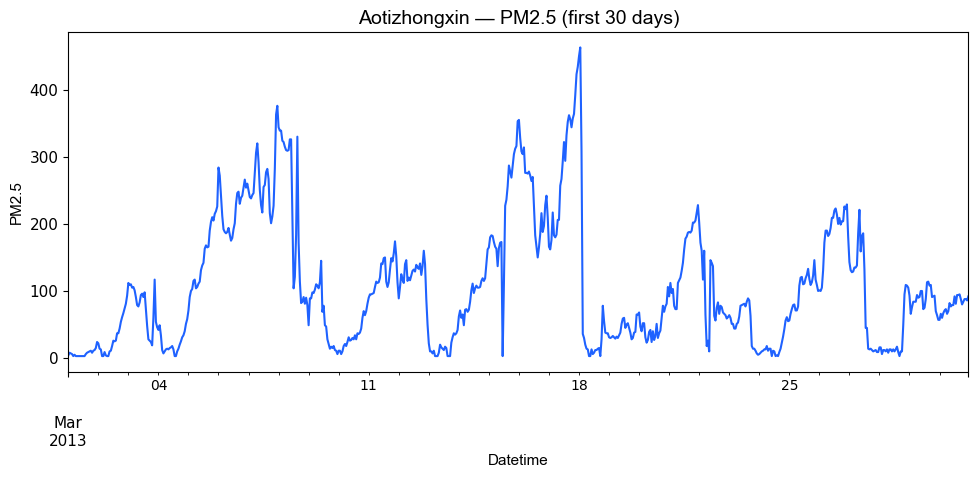

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\images\05_rolling_statistics.png


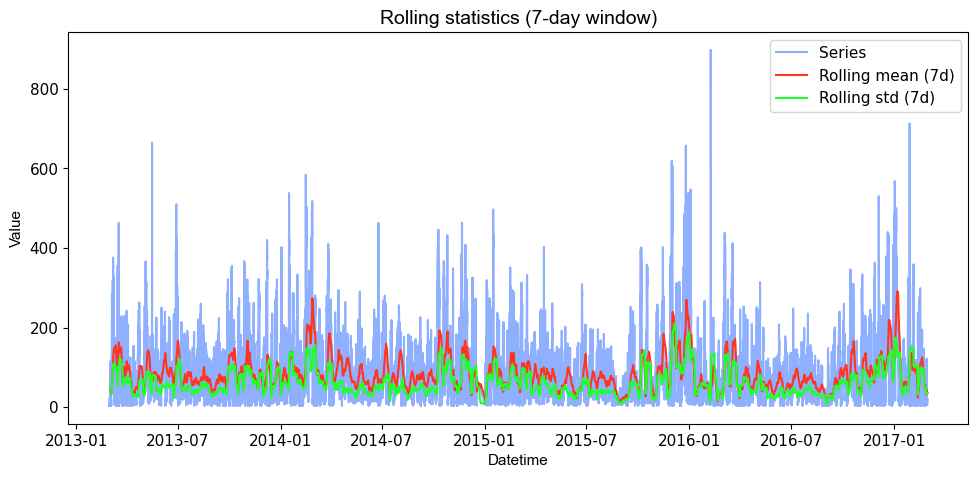

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\images\05_hourly_seasonality.png


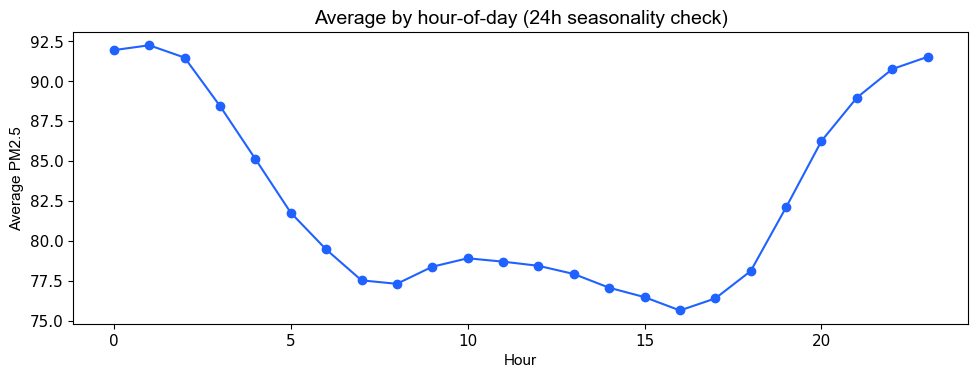

In [4]:
diag = describe_time_series(s)
print(json.dumps(diag, ensure_ascii=False, indent=2))

# Plot raw series (zoom a bit)
fig, ax = plt.subplots(figsize=(10, 5))
s.iloc[:24*30].plot(ax=ax, color='#1F62FF')  # first 30 days
ax.set_title(f'{STATION} — {VALUE_COL} (first 30 days)', fontsize=14, fontfamily='Arial')
ax.set_xlabel('Datetime', fontsize=11, fontfamily='Arial')
ax.set_ylabel(VALUE_COL, fontsize=11, fontfamily='Arial')
ax.tick_params(axis='both', labelsize=11)
plt.tight_layout(pad=1.5)

# Lưu biểu đồ
plt.savefig(IMAGES_PATH / '05_raw_timeseries_30days.png', dpi=300, bbox_inches='tight')
print('Saved:', IMAGES_PATH / '05_raw_timeseries_30days.png')
plt.show()

# Rolling mean/std for intuition about stationarity
roll_mean = s.rolling(24*7, min_periods=24*3).mean()  # 7-day window
roll_std  = s.rolling(24*7, min_periods=24*3).std()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(s.index, s.values, label='Series', alpha=0.5, color='#1F62FF')
ax.plot(roll_mean.index, roll_mean.values, label='Rolling mean (7d)', color='#FF351F')
ax.plot(roll_std.index, roll_std.values, label='Rolling std (7d)', color='#1FFF2A')
ax.set_title('Rolling statistics (7-day window)', fontsize=14, fontfamily='Arial')
ax.set_xlabel('Datetime', fontsize=11, fontfamily='Arial')
ax.set_ylabel('Value', fontsize=11, fontfamily='Arial')
ax.tick_params(axis='both', labelsize=11)
ax.legend(fontsize=11)
plt.tight_layout(pad=1.5)

# Lưu biểu đồ
plt.savefig(IMAGES_PATH / '05_rolling_statistics.png', dpi=300, bbox_inches='tight')
print('Saved:', IMAGES_PATH / '05_rolling_statistics.png')
plt.show()

# Seasonality check: average by hour-of-day
tmp = pd.DataFrame({'y': s.values}, index=s.index)
hod = tmp.groupby(tmp.index.hour)['y'].mean()
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(hod.index, hod.values, color='#1F62FF', marker='o')
ax.set_title('Average by hour-of-day (24h seasonality check)', fontsize=14, fontfamily='Arial')
ax.set_xlabel('Hour', fontsize=11, fontfamily='Arial')
ax.set_ylabel('Average PM2.5', fontsize=11, fontfamily='Arial')
ax.tick_params(axis='both', labelsize=11)
plt.tight_layout(pad=1.5)

# Lưu biểu đồ
plt.savefig(IMAGES_PATH / '05_hourly_seasonality.png', dpi=300, bbox_inches='tight')
print('Saved:', IMAGES_PATH / '05_hourly_seasonality.png')
plt.show()

## 3) Split theo thời gian + ACF/PACF (gợi ý p, q)
ACF/PACF giúp nhìn cấu trúc tương quan theo lag.
Trong thực tế ta vẫn cần kiểm chứng bằng AIC/BIC.

train: 2013-03-01 00:00:00 -> 2016-12-31 23:00:00 | n= 33648
test : 2017-01-01 00:00:00 -> 2017-02-28 23:00:00 | n= 1416
Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\images\05_acf_plot.png


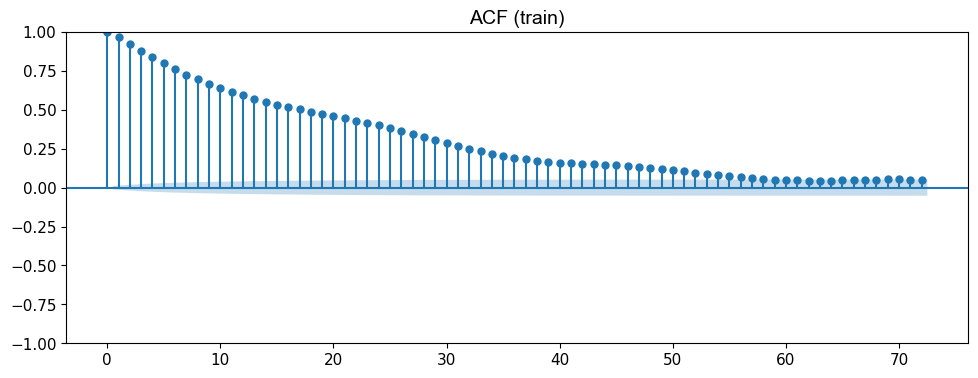

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\images\05_pacf_plot.png


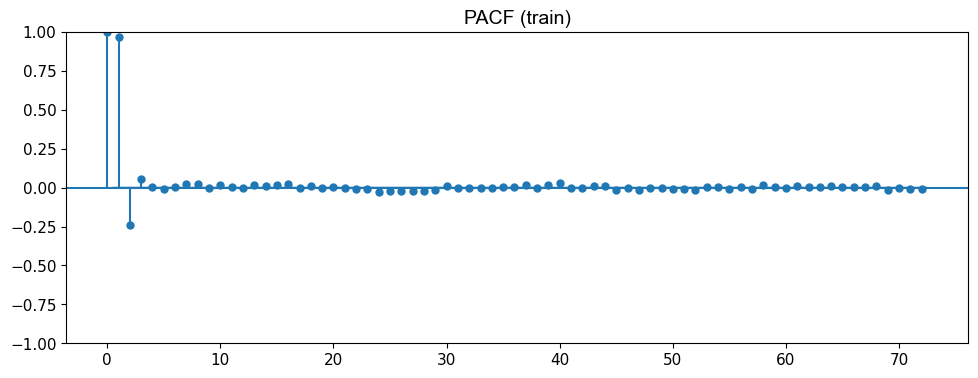

In [5]:
train, test = train_test_split_series(s, cutoff=CUTOFF)
print('train:', train.index.min(), '->', train.index.max(), '| n=', len(train))
print('test :', test.index.min(), '->', test.index.max(), '| n=', len(test))

x = train.dropna()
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(x, lags=72, ax=ax)  # 3 days
ax.set_title('ACF (train)', fontsize=14, fontfamily='Arial')
ax.tick_params(axis='both', labelsize=11)
plt.tight_layout(pad=1.5)

# Lưu biểu đồ ACF
plt.savefig(IMAGES_PATH / '05_acf_plot.png', dpi=300, bbox_inches='tight')
print('Saved:', IMAGES_PATH / '05_acf_plot.png')
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(x, lags=72, ax=ax, method='ywm')
ax.set_title('PACF (train)', fontsize=14, fontfamily='Arial')
ax.tick_params(axis='both', labelsize=11)
plt.tight_layout(pad=1.5)

# Lưu biểu đồ PACF
plt.savefig(IMAGES_PATH / '05_pacf_plot.png', dpi=300, bbox_inches='tight')
print('Saved:', IMAGES_PATH / '05_pacf_plot.png')
plt.show()

## 4) Grid search ARIMA(p,d,q) theo AIC/BIC và dự báo
Giữ grid nhỏ để chạy nhanh trong lab.

Best order: (1, 0, 3) | best aic = 294792.70634829276


,datetime,y_true,y_pred,lower,upper
0,2017-01-01 00:00:00,485.0,460.796484,422.895015,498.697953
1,2017-01-01 01:00:00,477.0,442.790204,383.069985,502.510423
2,2017-01-01 02:00:00,454.0,425.685614,351.185256,500.185972
3,2017-01-01 03:00:00,418.0,409.842475,324.425762,495.259189
4,2017-01-01 04:00:00,438.0,394.729760,300.472291,488.987228


Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\05_predictions_sample.csv
{'rmse': 104.10353113855875, 'mae': 77.69129505176798}
Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\images\05_forecast_vs_actual.png


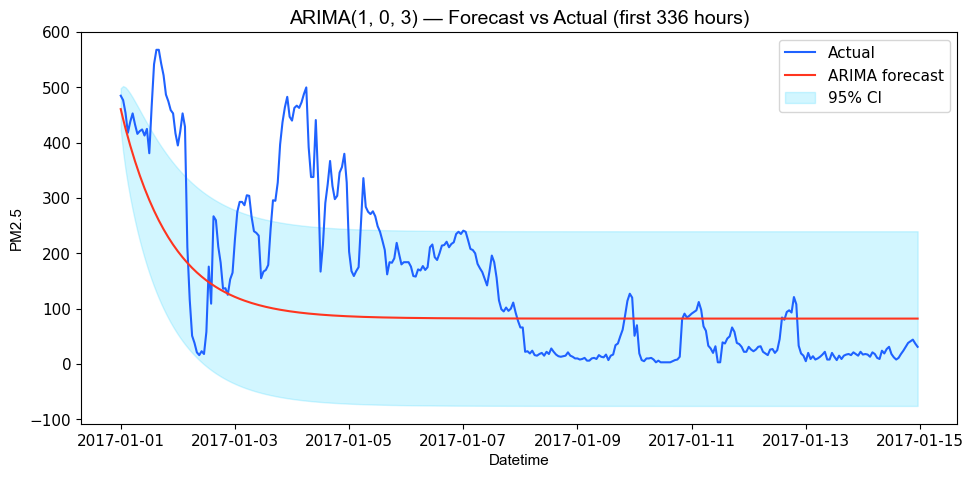

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\05_arima_pm25_summary.json


In [6]:
gs = grid_search_arima_order(train, p_max=P_MAX, q_max=Q_MAX, d_max=D_MAX, d=None, ic=IC)
best_order = gs['best_order']
print('Best order:', best_order, '| best', IC, '=', gs['best_score'])

out = fit_arima_and_forecast(train, steps=len(test), order=best_order)
yhat = out['forecast']
ci = out['conf_int']

# Align with test index (same length)
pred_df = pd.DataFrame({
    'datetime': test.index[:len(yhat)],
    'y_true': test.values[:len(yhat)],
    'y_pred': yhat.values,
    'lower': ci.iloc[:,0].values,
    'upper': ci.iloc[:,1].values,
})
display(pred_df.head())

# Lưu predictions sample
pred_df.head(100).to_csv(DATA_PATH / '05_predictions_sample.csv', index=False)
print('Saved:', DATA_PATH / '05_predictions_sample.csv')

# Error metrics
mask = np.isfinite(pred_df['y_true']) & np.isfinite(pred_df['y_pred'])
rmse = float(np.sqrt(np.mean((pred_df.loc[mask,'y_true'] - pred_df.loc[mask,'y_pred'])**2)))
mae  = float(np.mean(np.abs(pred_df.loc[mask,'y_true'] - pred_df.loc[mask,'y_pred'])))
print({'rmse': rmse, 'mae': mae})

# Plot forecast (sample window)
plot_n = min(24*14, len(pred_df))  # first 14 days of test
p = pred_df.iloc[:plot_n].copy()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(p['datetime'], p['y_true'], label='Actual', color='#1F62FF')
ax.plot(p['datetime'], p['y_pred'], label='ARIMA forecast', color='#FF351F')
ax.fill_between(p['datetime'], p['lower'], p['upper'], alpha=0.2, color='#1FD2FF', label='95% CI')
ax.set_title(f'ARIMA{best_order} — Forecast vs Actual (first {plot_n} hours)', fontsize=14, fontfamily='Arial')
ax.set_xlabel('Datetime', fontsize=11, fontfamily='Arial')
ax.set_ylabel('PM2.5', fontsize=11, fontfamily='Arial')
ax.tick_params(axis='both', labelsize=11)
ax.legend(fontsize=11)
plt.tight_layout(pad=1.5)

# Lưu biểu đồ
plt.savefig(IMAGES_PATH / '05_forecast_vs_actual.png', dpi=300, bbox_inches='tight')
print('Saved:', IMAGES_PATH / '05_forecast_vs_actual.png')
plt.show()

# Save artifacts
out_dir = (PROJECT_ROOT / 'data/processed')
out_dir.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(out_dir / f'{ARTIFACTS_PREFIX}_predictions.csv', index=False)
out['result'].save(out_dir / f'{ARTIFACTS_PREFIX}_model.pkl')
summary = {
    'station': STATION,
    'value_col': VALUE_COL,
    'cutoff': CUTOFF,
    'best_order': best_order,
    'ic': IC,
    'best_score': gs['best_score'],
    'rmse': rmse,
    'mae': mae,
    'diagnostics': diag,
}
with open(out_dir / f'{ARTIFACTS_PREFIX}_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print('Saved:', out_dir / f'{ARTIFACTS_PREFIX}_summary.json')